In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:]) 

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Exercises

- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.
- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

### Exercise 1

In [54]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.zeros((fan_in, fan_out)) / fan_in**0.5  #, generator=g
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
  

class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    
    self.gamma = torch.zeros(dim)
    self.beta = torch.zeros(dim)
    
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
    
  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdims=True)
      xvar = x.var(0, keepdims=True, unbiased=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
      
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
  

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []
      

In [64]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.zeros((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *=  5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47551


In [65]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)
  
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  
  loss.backward()
  
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr * p.grad).std()/ p.data.std()).log10().item() for p in parameters])
  
  # if i >= 1000:
  #   break

      0/ 200000: 3.2958
  10000/ 200000: 2.7441
  20000/ 200000: 2.8786
  30000/ 200000: 2.8612
  40000/ 200000: 2.7905
  50000/ 200000: 2.8820
  60000/ 200000: 2.8168
  70000/ 200000: 2.4080
  80000/ 200000: 2.7652
  90000/ 200000: 2.8202
 100000/ 200000: 2.8007
 110000/ 200000: 2.6762
 120000/ 200000: 2.8276
 130000/ 200000: 2.5795
 140000/ 200000: 2.8856
 150000/ 200000: 2.9309
 160000/ 200000: 2.8699
 170000/ 200000: 2.5973
 180000/ 200000: 3.1450
 190000/ 200000: 2.6769


layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


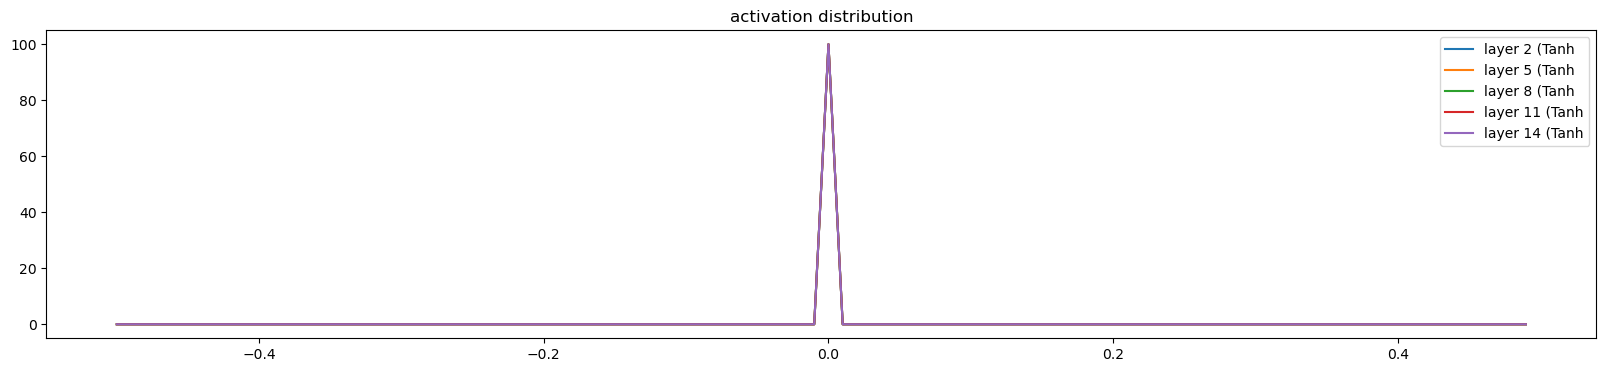

In [66]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


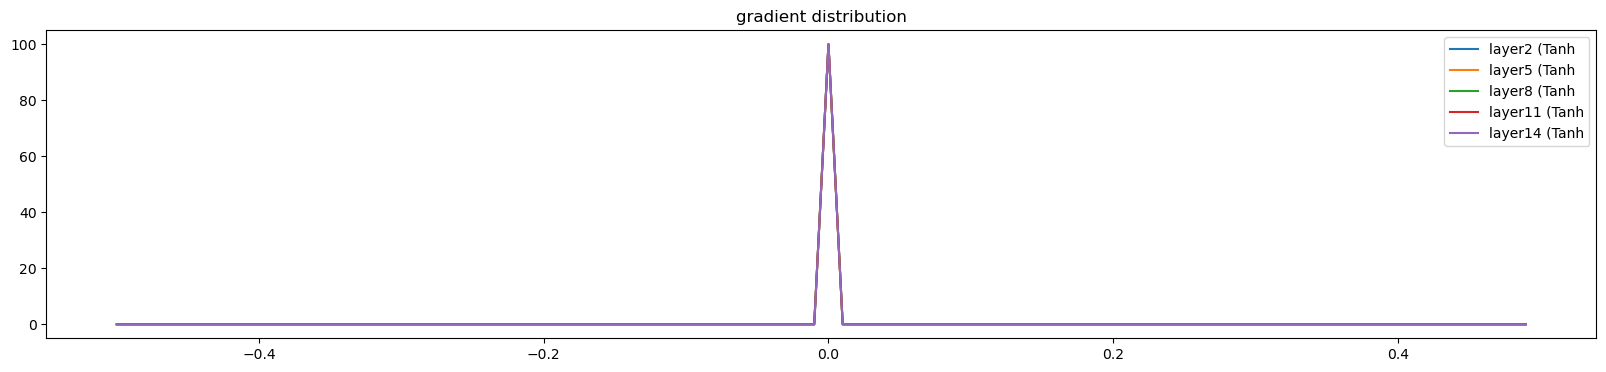

In [67]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.std(), t.mean()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer{i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution');

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad data ratio nan
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad data ratio nan


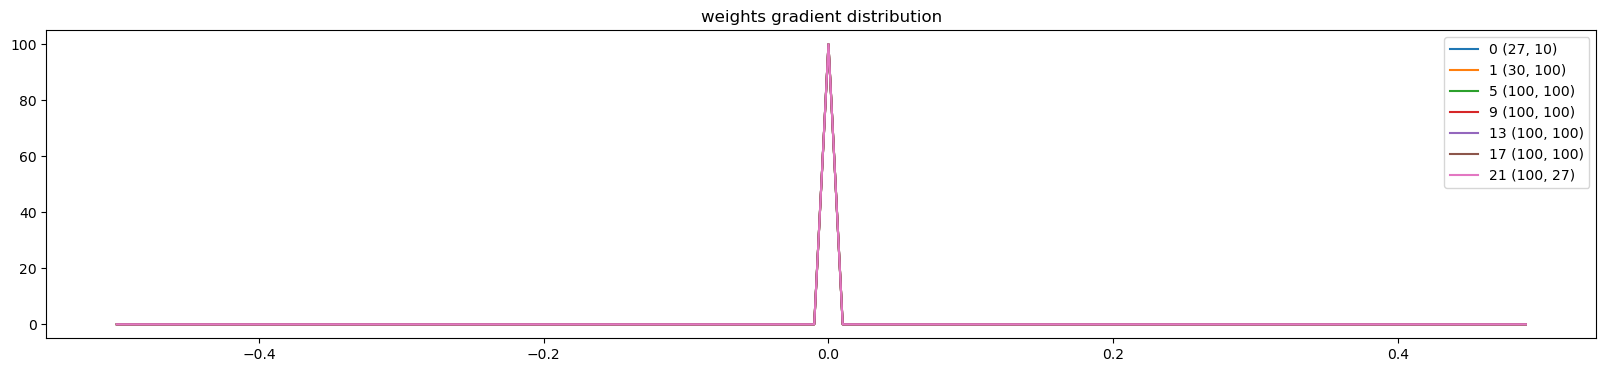

In [68]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad data ratio %e' %( tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution');

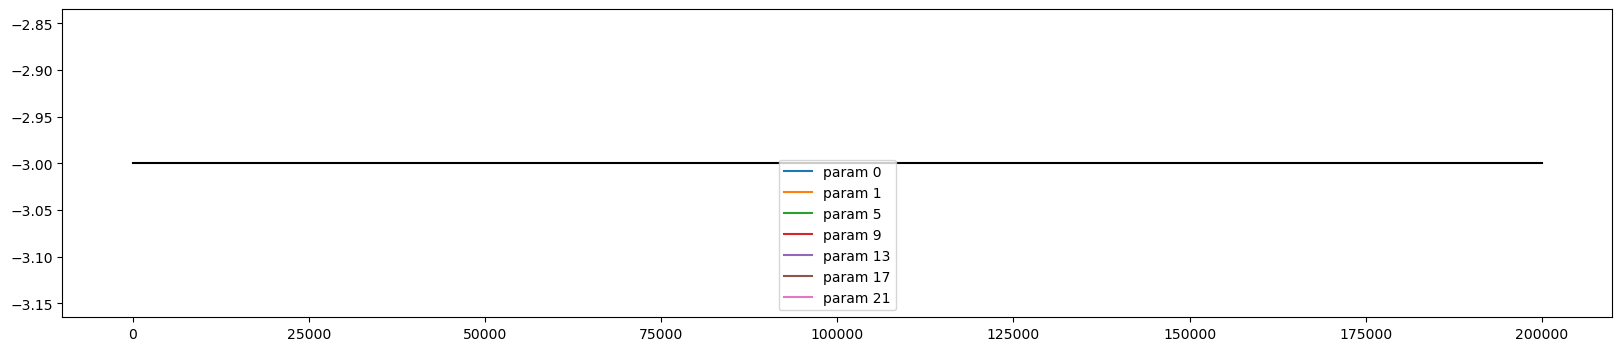

In [69]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [70]:
parameters

[tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0

In [63]:
[p.grad for p in parameters]

[tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0

In [45]:
len(parameters[-2])

27

I feel the idea here was that C, Gamma, and Beta remains unchanged. That way our network learns partially. Even if we keep literally everything zero, including C, Gamma, and Beta, the network will still train partially because of the last cross entropy set

### Exercise 2

E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [293]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5  #, generator=g
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdims=True)
      xvar = x.var(0, keepdims=True, unbiased=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    # print(xhat)
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


In [320]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *=  5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

26951


In [321]:
max_steps = 200
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)
  
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  
  loss.backward()
  
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr * p.grad).std()/ p.data.std()).log10().item() for p in parameters])
  
  # if i >= 1000:
  #   break

      0/    200: 3.3073


In [322]:
with torch.no_grad():

  dev_embd = C[Xdev]
  x = dev_embd.view(dev_embd.shape[0], -1)
  for layer in layers:
    if isinstance(layer, BatchNorm1d):
      layer.training=False
    x = layer(x)
  loss = F.cross_entropy(x, Ydev)
  print(loss.item())
  # h_pre_act = embd @ layers[0].parameters()[0] + layers[0].parameters()[1]
  # h_normed = layers[1].gamma * (h_pre_act - layers[1].running_mean / (layers[1].running_var**2 + layers[1].eps)) + layers[1].beta

2.7410805225372314


In [324]:
# folding the norm layer trial #1
with torch.no_grad():
  
  dev_embd = C[Xdev]
  x = dev_embd.view(dev_embd.shape[0], -1)
  for i, layer in enumerate(layers[:-1]):
    # print(layer)
    if isinstance(layers[i+1], BatchNorm1d):
      x_bar = layers[i+1].gamma * (x @ layers[i].parameters()[0] )
      # print(w.shape, layers[i+1].gamma.shape, layers[i].parameters()[0].shape)
      b = layers[i+1].gamma * layers[i].parameters()[1] + layers[i+1].beta
      x = x_bar + b 
      x = (x - layers[i+1].running_mean) / torch.sqrt(layers[i+1].running_var + layers[i+1].eps)
      # print(x.shape)
    elif isinstance(layer, BatchNorm1d):
      pass
    elif isinstance(layer, Tanh):
      x = layer(x)
  x = (x - layers[-1].running_mean) / torch.sqrt(layers[-1].running_var + layers[-1].eps)
  loss = F.cross_entropy(x, Ydev)
  print(loss.item())

2.873305082321167


In [325]:
# folding the norm layer trial #2
with torch.no_grad():
  
  dev_embd = C[Xdev]
  x = dev_embd.view(dev_embd.shape[0], -1)
  for i, layer in enumerate(layers[:-1]):
    # print(layer)
    if isinstance(layers[i+1], BatchNorm1d):
      w = layers[i+1].gamma * (layers[i].parameters()[0] )
      # print(w.shape, layers[i+1].gamma.shape, layers[i].parameters()[0].shape)
      b = layers[i].parameters()[1] + layers[i+1].beta
      x = x @ w + b 
      x = (x - layers[i+1].running_mean) / torch.sqrt(layers[i+1].running_var + layers[i+1].eps)
      # print(x.shape)
    elif isinstance(layer, BatchNorm1d):
      pass
    else:
      x = layer(x)
  x = (x - layers[-1].running_mean) / torch.sqrt(layers[-1].running_var + layers[-1].eps)
  loss = F.cross_entropy(x, Ydev)
  print(loss.item())

2.873305082321167


In [345]:
# folding the norm layer trial #3 **worked***

# In this trial we will take step-by-step approach vs. the loop
# We do this because we need to swap the step in batch norm. In actual batch norm we first normalize then scale-shift
# This is not possible in 'folding norm' so we first take scale-shift then normalize

with torch.no_grad():
  dev_embd = C[Xdev]
  x = dev_embd.view(dev_embd.shape[0], -1)

  h = x @ layers[0].parameters()[0] + layers[0].parameters()[1]
  h_hat = layers[1].gamma * h + layers[1].beta
  h_norm = (h_hat - layers[1].running_mean)/(torch.sqrt(layers[1].running_var + layers[1].eps))
  h_out = layers[2](h_norm)
  
  x2 = h_out @ layers[3].parameters()[0] + layers[3].parameters()[1]
  x2_hat = layers[4].gamma * x2 + layers[4].beta
  x2_norm = (x2_hat - layers[4].running_mean)/(torch.sqrt(layers[4].running_var + layers[4].eps))
  x2_out = layers[5](x2_norm)
  
  x3 = x2_out @ layers[6].parameters()[0] + layers[6].parameters()[1]
  x3_hat = layers[7].gamma * x3 + layers[7].beta
  x3_norm = (x3_hat - layers[7].running_mean)/(torch.sqrt(layers[7].running_var + layers[7].eps))
  x3_out = layers[8](x3_norm)
  
  x4 = x3_out @ layers[9].parameters()[0] + layers[9].parameters()[1]
  x4_hat = layers[10].gamma * x4 + layers[10].beta
  x4_norm = (x4_hat - layers[10].running_mean)/(torch.sqrt(layers[10].running_var + layers[10].eps))
  
  loss = F.cross_entropy(x4_norm, Ydev)
  print(f'(Ordinary Batch Norm with steps swapped) Loss: {loss.item()}')
  
with (torch.no_grad()):
  dev_embd = C[Xdev]
  x = dev_embd.view(dev_embd.shape[0], -1)

  w2 = layers[1].gamma *  layers[0].parameters()[0]
  b2 =  layers[1].gamma * layers[0].parameters()[1] + layers[1].beta
  h_hat = x @ w2 + b2
  h_norm = (h_hat - layers[1].running_mean)/(torch.sqrt(layers[1].running_var + layers[1].eps))
  h_out = layers[2](h_norm) # activation tanh
  
  w3 = layers[4].gamma * layers[3].parameters()[0]
  b3 = layers[4].gamma * layers[3].parameters()[1] + layers[4].beta
  x2_hat = h_out @ w3 + b3
  x2_norm = (x2_hat - layers[4].running_mean)/(torch.sqrt(layers[4].running_var + layers[4].eps))
  x2_out = layers[5](x2_norm)
  
  w4 = layers[7].gamma * layers[6].parameters()[0]
  b4 = layers[7].gamma * layers[6].parameters()[1] + layers[7].beta
  x3_hat = x2_out @ w4 + b4
  x3_norm = (x3_hat - layers[7].running_mean)/(torch.sqrt(layers[7].running_var + layers[7].eps))
  x3_out = layers[8](x3_norm)
  
  w5 = layers[10].gamma * layers[9].parameters()[0]
  b5 = layers[10].gamma * layers[9].parameters()[1] + layers[10].beta
  x4_hat = x3_out @ w5 + b5
  x4_norm = (x4_hat - layers[10].running_mean)/(torch.sqrt(layers[10].running_var + layers[10].eps))

  loss = F.cross_entropy(x4_norm, Ydev)
  print(f'(Folding Norm) \t\t\t\t\t\t\t Loss: {loss.item()}')

(Ordinary Batch Norm with steps swapped) Loss: 2.7809619903564453
(Folding Norm) 							 Loss: 2.7809619903564453


#### Tiny example for folding (trial #2b)

In [312]:
n_embd = 2
n_hidden = 5
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *=  5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

315


In [313]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)
  
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  
  loss.backward()
  
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr * p.grad).std()/ p.data.std()).log10().item() for p in parameters])
  
    break

      0/ 200000: 3.3058


In [314]:
# loss with regular batch norm
with torch.no_grad():

  dev_embd = C[Xdev[:5]]
  x = dev_embd.view(dev_embd.shape[0], -1)
  for i, layer in enumerate(layers):
    if isinstance(layer, BatchNorm1d):
      layer.training = False
    x = layer(x)
    # if i == 1:
    #   # print(layer)
    #   print(x)
    #   break
  loss = F.cross_entropy(x, Ydev[:5])
  print(loss.item())

3.340766429901123


In [315]:
# step by step of batch norm to debug
with torch.no_grad():
  dev_embd = C[Xdev[:5]]
  x = dev_embd.view(dev_embd.shape[0], -1)
  
  h = x @ layers[0].parameters()[0] + layers[0].parameters()[1] # Linear
  # print(h)
  h_hat = (h - layers[1].running_mean)/(torch.sqrt(layers[1].running_var + layers[1].eps)) # normalization
  # print(h_hat)
  h_out = layers[1].gamma * h_hat + layers[1].beta # scale
  # print(h_out)
  h_act = layers[2](h_out) # activation tanh
  x2 = h_act @ layers[3].parameters()[0] + layers[3].parameters()[1] # linear
  x2_hat = (x2 - layers[4].running_mean)/(torch.sqrt(layers[4].running_var + layers[4].eps)) # normalization
  x2_out = layers[4].gamma * x2_hat + layers[4].beta # scale

  small_loss = F.cross_entropy(x2_out, Ydev[:5])
  print(small_loss.item())


3.340766429901123


In [316]:
# swapping the steps in batch norm. Because that's how it'll be in the next folding step
with torch.no_grad():
  # print(x @ layers[0].parameters()[0] + layers[0].parameters()[1])
  h = x @ layers[0].parameters()[0] + layers[0].parameters()[1]
  # print(layers[1].gamma * h + layers[1].beta)
  h_hat = layers[1].gamma * h + layers[1].beta
  # print((h_hat - layers[1].running_mean)/(torch.sqrt(layers[1].running_var + layers[1].eps)))
  h_out = (h_hat - layers[1].running_mean)/(torch.sqrt(layers[1].running_var + layers[1].eps))
  h_out = layers[2](h_out) # activation tanh
  x2 = h_out @ layers[3].parameters()[0] + layers[3].parameters()[1] # linear
  x2_hat = layers[4].gamma * x2 + layers[4].beta
  x2_out = (x2_hat - layers[4].running_mean)/(torch.sqrt(layers[4].running_var + layers[4].eps))
  small_loss = F.cross_entropy(x2_out, Ydev[:5])
  print(small_loss)


tensor(3.3397)


In [317]:
# folding the batch norm
with (torch.no_grad()):
  # print(x @ layers[0].parameters()[0] + layers[0].parameters()[1])
  w2 = layers[1].gamma *  layers[0].parameters()[0]
  b2 =  layers[1].gamma * layers[0].parameters()[1] + layers[1].beta
  # print(layers[1].gamma * h + layers[1].beta)
  h_hat = x @ w2 + b2
  # print((h_hat - layers[1].running_mean)/(torch.sqrt(layers[1].running_var + layers[1].eps)))
  h_out = (h_hat - layers[1].running_mean)/(torch.sqrt(layers[1].running_var + layers[1].eps))
  h_out = layers[2](h_out) # activation tanh
  
  w3 = layers[4].gamma * layers[3].parameters()[0]
  b3 = layers[4].gamma * layers[3].parameters()[1] + layers[4].beta
  x2_hat = h_out @ w3 + b3
  x2_out = (x2_hat - layers[4].running_mean)/(torch.sqrt(layers[4].running_var + layers[4].eps))
  small_loss = F.cross_entropy(x2_out, Ydev[:5])
  print(small_loss)

tensor(3.3397)


## Practice Session 
Clarifying some questions

In [169]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *(5/3)/((n_embd * block_size)**0.5) # *0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
# bnmean_running = torch.ones(1, n_hidden)
# bnstd_running = torch.zeros(1, n_hidden)

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [151]:
embd = C[Xtr]
embd = embd.view(embd.shape[0], -1)
h_pre_act = embd @ W1 + b1
h = torch.tanh(h_pre_act)
h.retain_grad()
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.backward()
loss.item()

3.296825647354126

[Unsolved]: The gradient graph for h looks the same even after scaling W1 and b1

In [170]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  
  bnmeani = hpreact.mean(0, keepdims=True)
  bnstdi = hpreact.std(0, keepdims=True)
  # hpreact = (hpreact - bnmeani) / bnstdi
  hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias
  
  # with torch.no_grad():
  #   bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
  #   bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  
  h = torch.tanh(hpreact) # hidden layer
  h.retain_grad()
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  # if i > 1000:
  #   break
  


      0/ 200000: 3.3014
  10000/ 200000: 2.4789
  20000/ 200000: 2.3364
  30000/ 200000: 2.1072
  40000/ 200000: 2.0523
  50000/ 200000: 2.4329
  60000/ 200000: 2.2905
  70000/ 200000: 2.0826
  80000/ 200000: 2.0123
  90000/ 200000: 2.0183
 100000/ 200000: 2.4473
 110000/ 200000: 2.0486
 120000/ 200000: 2.1925
 130000/ 200000: 2.3583
 140000/ 200000: 2.2693
 150000/ 200000: 2.3672
 160000/ 200000: 2.0888
 170000/ 200000: 2.0872
 180000/ 200000: 2.4111
 190000/ 200000: 1.8808


-0.030599767342209816, 1.3164416551589966


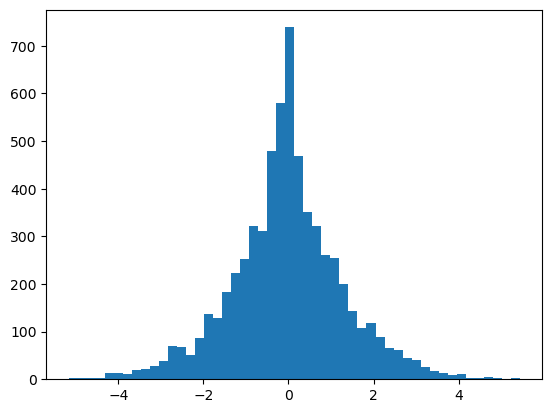

In [171]:
# hpreact with bngain and bnbias
plt.hist(hpreact.view(-1).tolist(), bins=50);
print(f'{hpreact.mean().item()}, {hpreact.std().item()}')

7.450580430390374e-11, 0.9843279123306274


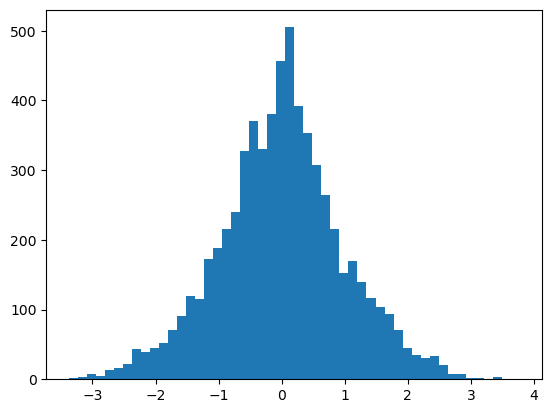

In [164]:
# hpreact without bngain and bnbias
plt.hist(hpreact.view(-1).tolist(), bins=50);
print(f'{hpreact.mean().item()}, {hpreact.std().item()}')

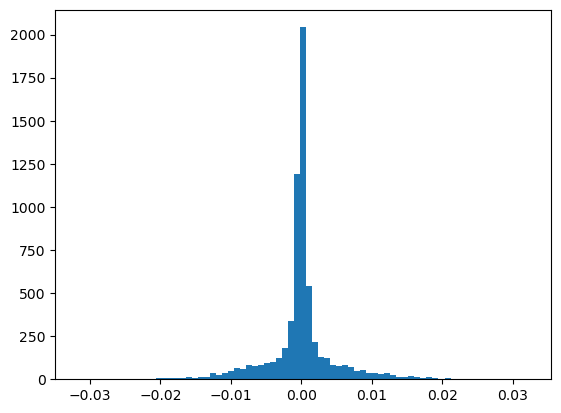

In [156]:
plt.hist(h.grad.view(-1).tolist(), bins=75);

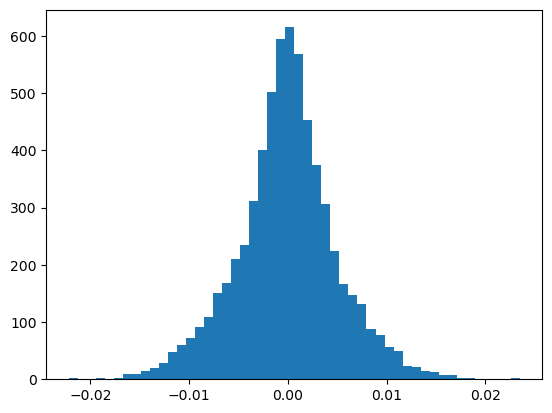

In [149]:
plt.hist(h.grad.view(-1).tolist(), bins=50);

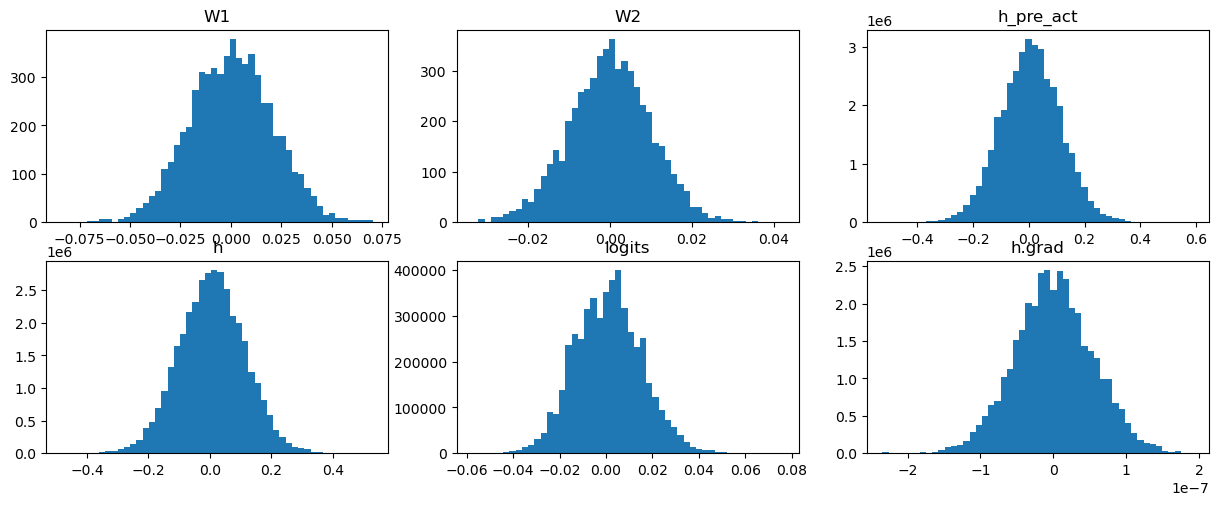

In [132]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5.5))
axs = axs.flatten()

variables = [W1, W2, h_pre_act, h, logits, h.grad]
title = ['W1', 'W2', 'h_pre_act', 'h', 'logits', 'h.grad']

for i, var in enumerate(variables):
  axs[i].hist(var.view(-1).detach().numpy(), bins = 50)
  axs[i].set_title(f'{title[i]}')

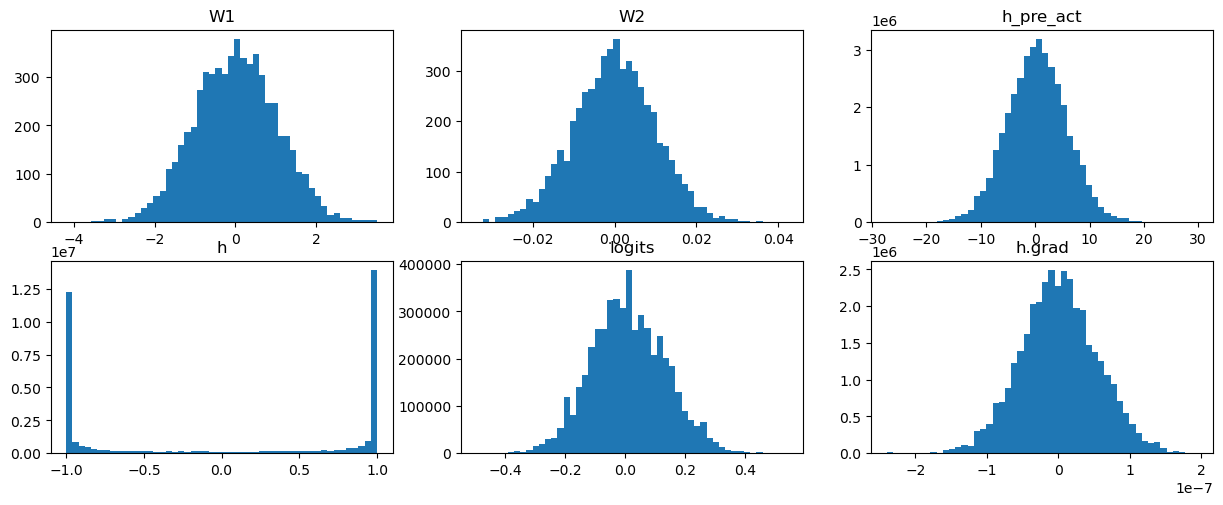

In [112]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5.5))
axs = axs.flatten()

variables = [W1, W2, h_pre_act, h, logits, h.grad]
title = ['W1', 'W2', 'h_pre_act', 'h', 'logits', 'h.grad']

for i, var in enumerate(variables):
  axs[i].hist(var.view(-1).detach().numpy(), bins = 50)
  axs[i].set_title(f'{title[i]}')

Mini example of batch normalization and the logic behind turning off the bias
- It's hard for me to understand why turning off bias is okay
[Solution]: Think what effect does adding a bias have? It allows us to move left or right on an axis. Without bias our points would be centered at zero. When we add bias we can move around. So when we remove the mean, the points move to center. Hence, the effect of bias is negated. [Watch this](https://www.youtube.com/watch?v=fMAElNVN4S0&list=PLYnFjKiXoXgLymbmn4TbSK4LjsvYwkYtr&index=10&ab_channel=Rohan-Paul-AI)

In [189]:
small_x = torch.randint(0, 3, (3, 5), dtype=float, generator=g)
small_w1 = torch.randint(1, 3, (5, 3), dtype=float, generator=g)
small_b1 = torch.randint(1, 3, (3,), dtype=float, generator=g)

small_x, small_w1, small_b1

(tensor([[2., 2., 0., 2., 0.],
         [1., 2., 0., 1., 2.],
         [0., 0., 0., 1., 1.]], dtype=torch.float64),
 tensor([[2., 2., 1.],
         [1., 2., 1.],
         [1., 1., 1.],
         [2., 1., 1.],
         [1., 1., 2.]], dtype=torch.float64),
 tensor([2., 2., 1.], dtype=torch.float64))

In [204]:
without_bias = small_x @ small_w1
this_mean = without_bias.mean()
this_std = without_bias.std()
print(this_mean.item(), this_std.item())
without_bias

6.555555555555555 3.166666666666667


tensor([[10., 10.,  6.],
        [ 8.,  9.,  8.],
        [ 3.,  2.,  3.]], dtype=torch.float64)

In [205]:
without_bias - this_mean

tensor([[ 3.4444,  3.4444, -0.5556],
        [ 1.4444,  2.4444,  1.4444],
        [-3.5556, -4.5556, -3.5556]], dtype=torch.float64)

In [206]:
(without_bias - this_mean )/ this_std

tensor([[ 1.0877,  1.0877, -0.1754],
        [ 0.4561,  0.7719,  0.4561],
        [-1.1228, -1.4386, -1.1228]], dtype=torch.float64)

In [200]:
with_bias = small_x @ small_w1 + small_b1
wb_mean = with_bias.mean()
wb_std = with_bias.std()
print(wb_mean.item(), wb_std.item())
with_bias

8.222222222222221 3.3082388735465345


tensor([[12., 12.,  7.],
        [10., 11.,  9.],
        [ 5.,  4.,  4.]], dtype=torch.float64)

In [208]:
with_bias - wb_mean

tensor([[ 3.7778,  3.7778, -1.2222],
        [ 1.7778,  2.7778,  0.7778],
        [-3.2222, -4.2222, -4.2222]], dtype=torch.float64)

In [202]:
(with_bias - wb_mean )/ wb_std

tensor([[ 1.1419,  1.1419, -0.3694],
        [ 0.5374,  0.8397,  0.2351],
        [-0.9740, -1.2763, -1.2763]], dtype=torch.float64)